## 1. Import Required Libraries

Import essential packages for data manipulation, machine learning, visualization, and model persistence.

In [2]:
import argparse
import os
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Optional: SHAP for feature importance
try:
    import shap
    HAS_SHAP = True
except ImportError:
    HAS_SHAP = False
    print('SHAP not installed. Install via: pip install shap')

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## 2. Load and Explore Data

Load the CSV dataset and perform initial exploratory data analysis (EDA) to understand:
- Dataset shape and data types
- Summary statistics (mean, std, min, max)
- Missing values
- Class distribution (balance of scent types)

In [3]:
# Load dataset
data_path = Path('data/initial-smell-dataset.csv')
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumn data types:\n{df.dtypes}")
print(f"\nFirst few rows:\n{df.head()}")

Dataset shape: (9069, 16)

Column data types:
sample_id             int64
trial_number          int64
scent_id              int64
scent_name           object
phase                object
time_s              float64
temp_C              float64
humidity_pct        float64
pressure_kPa        float64
gas_bme             float64
srawVoc               int64
srawNox               int64
NO2                   int64
ethanol               int64
VOC_multichannel      int64
COandH2               int64
dtype: object

First few rows:
   sample_id  trial_number  scent_id scent_name     phase  time_s  temp_C  \
0          1             1         7      apple  baseline   0.000   23.48   
1          1             1         7      apple  baseline   1.215   23.48   
2          1             1         7      apple  baseline   2.430   23.48   
3          1             1         7      apple  baseline   3.645   23.47   
4          1             1         7      apple  baseline   4.860   23.47   

   humidity_

### 2.1 Summary Statistics and Missing Data

In [4]:
# Summary statistics
print("Summary Statistics:")
print(df.describe(include='all').T)

# Check for missing values
print("\nMissing values per column:")
missing = df.isna().sum()
if missing.sum() == 0:
    print("No missing values!")
else:
    print(missing[missing > 0])

Summary Statistics:
                   count unique       top  freq          mean          std  \
sample_id         9069.0    NaN       NaN   NaN     30.456831    17.325634   
trial_number      9069.0    NaN       NaN   NaN      2.996802     1.414015   
scent_id          9069.0    NaN       NaN   NaN      6.463447     3.460489   
scent_name          9069     12    coffee   784           NaN          NaN   
phase               9069      4  exposure  4440           NaN          NaN   
time_s            9069.0    NaN       NaN   NaN     91.248044    53.072342   
temp_C            9069.0    NaN       NaN   NaN     22.546607      1.29724   
humidity_pct      9069.0    NaN       NaN   NaN     39.443341     7.247558   
pressure_kPa      9069.0    NaN       NaN   NaN     100.89646     1.126037   
gas_bme           9069.0    NaN       NaN   NaN     67.649986    46.648087   
srawVoc           9069.0    NaN       NaN   NaN  27952.061859  1902.392139   
srawNox           9069.0    NaN       NaN   

### 2.2 Class Distribution

Visualize the distribution of scent classes to assess balance and ensure our cross-validation strategy accounts for class imbalance if present.

Scent ID Distribution:
scent_id
1     784
2     767
3     757
4     755
5     750
6     762
7     746
8     752
9     753
10    749
11    747
12    747
Name: count, dtype: int64


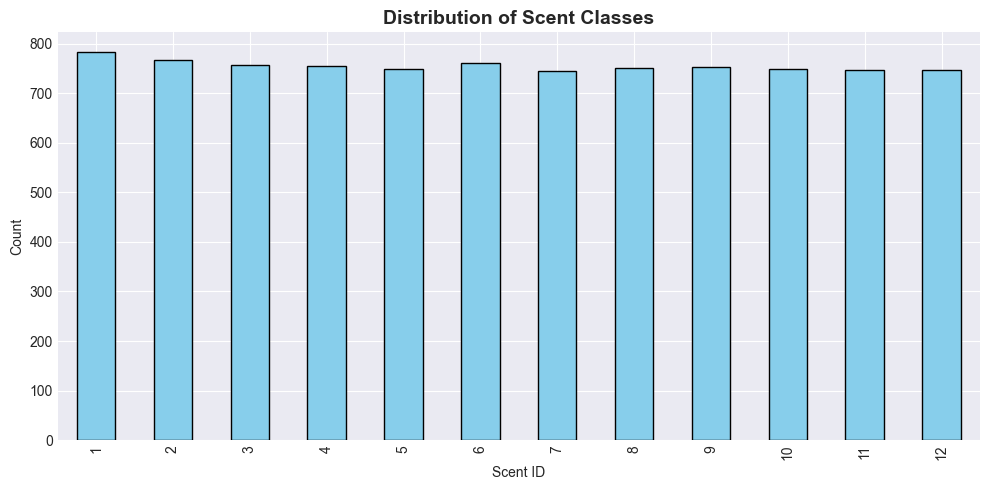


Scent Mapping (ID -> Name):
  1: coffee
  2: banana
  3: mango
  4: icecream
  5: grape
  6: pineapple
  7: apple
  8: melon
  9: coconut
  10: orange
  11: lavender
  12: lemon


In [5]:
# Class distribution
scent_counts = df['scent_id'].value_counts().sort_index()
print("Scent ID Distribution:")
print(scent_counts)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
scent_counts.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
ax.set_title('Distribution of Scent Classes', fontsize=14, fontweight='bold')
ax.set_xlabel('Scent ID')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

# Scent name mapping
scent_mapping = df[['scent_id', 'scent_name']].drop_duplicates().sort_values('scent_id')
print("\nScent Mapping (ID -> Name):")
for _, row in scent_mapping.iterrows():
    print(f"  {int(row['scent_id'])}: {row['scent_name']}")

### 2.3 Sensor Feature Distributions

Visualize distributions of key sensor readings (gas_bme, srawVoc, srawNox, NO2, ethanol, etc.) to understand their ranges and variations.

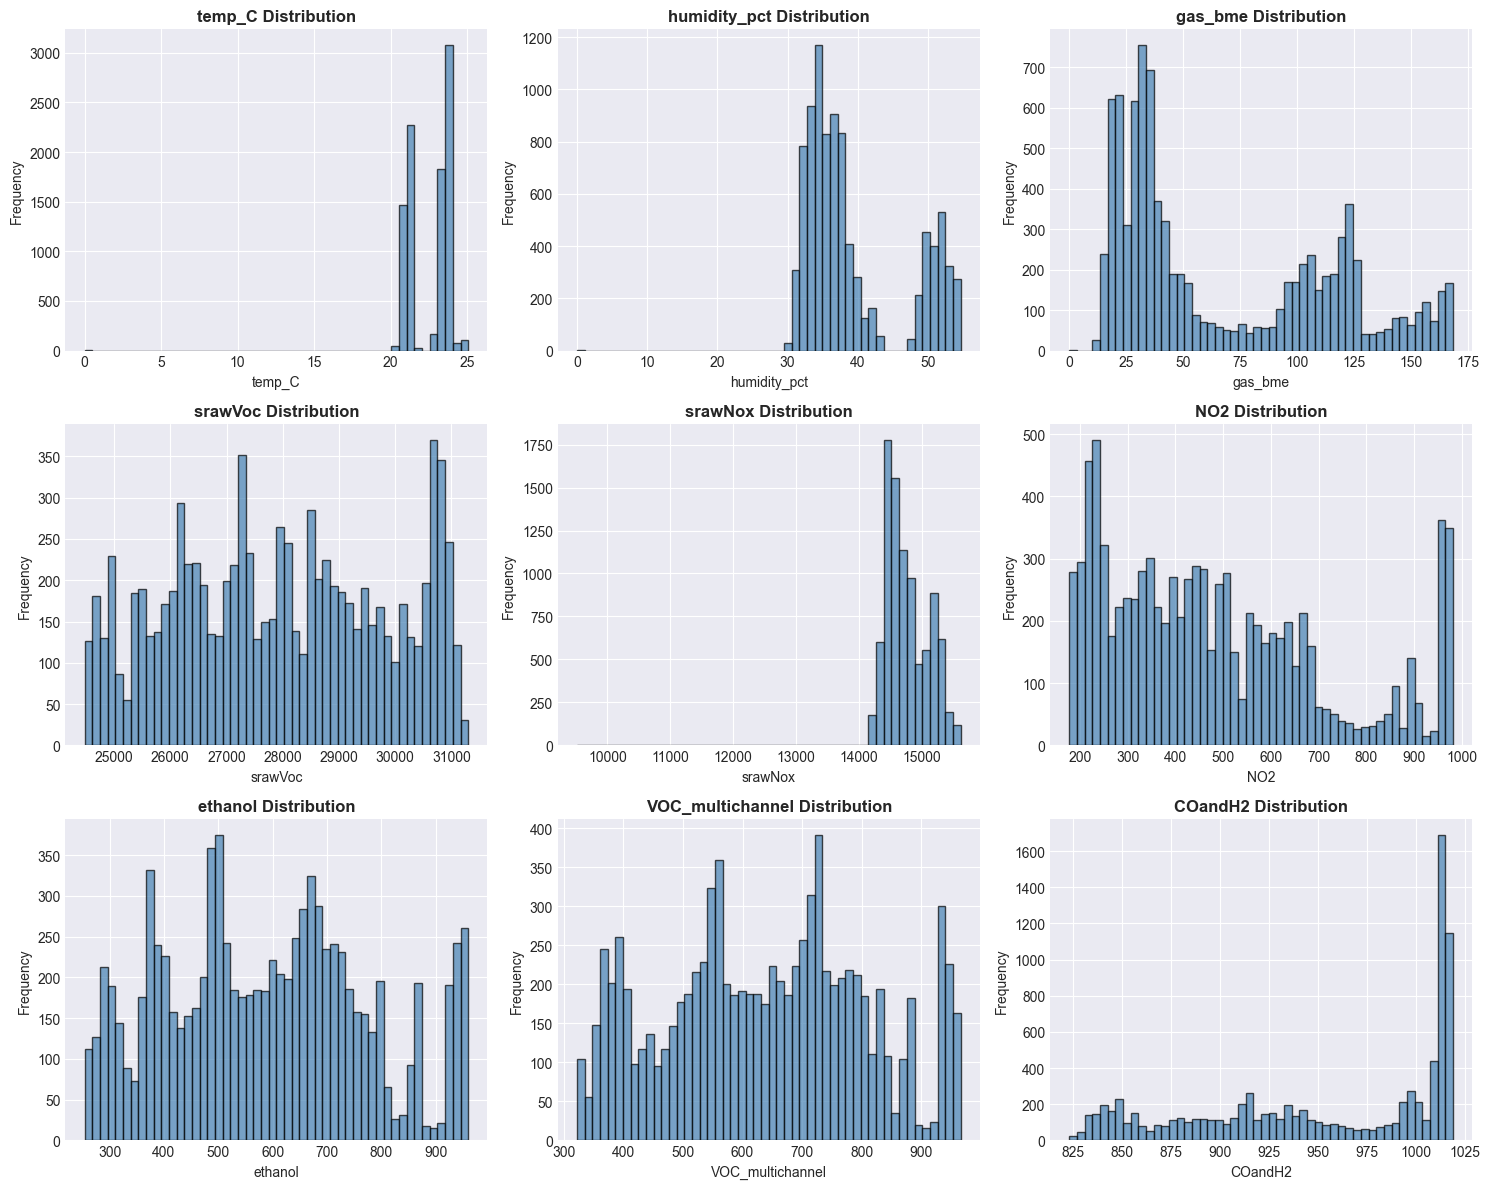

Analyzed 9 sensor features.


In [6]:
# Sensor columns (strong smell indicators only)
sensor_cols = ['gas_bme', 'srawVoc', 'VOC_multichannel', 'COandH2', 'srawNox', 'NO2', 'ethanol']

# Distribution plots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(sensor_cols):
    axes[idx].hist(df[col], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col} Distribution', fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Analyzed {len(sensor_cols)} sensor features.")


## 3. Data Preparation

Prepare features and target variable:
- Drop non-predictive columns (sample_id, scent_name, scent_id from features)
- Identify numeric and categorical features
- Split into training (80%) and test (20%) sets with stratification

In [7]:
# Define target variable (scent_id)
target = 'scent_id'
if target not in df.columns:
    raise RuntimeError(f"Target column '{target}' not found in dataset")

# Feature matrix: drop identifiers, scent_name, and environmental calibration vars
# Keep: trial_number, phase, time_s, and sensor readings (strong indicators only)
X = df.drop(columns=['sample_id', 'scent_name', 'scent_id', 'pressure_kPa', 'temp_C', 'humidity_pct'], errors='ignore')
y = df[target].astype(int)

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures:\n{X.columns.tolist()}")


Feature matrix shape: (9069, 13)
Target shape: (9069,)

Features:
['trial_number', 'phase', 'time_s', 'temp_C', 'humidity_pct', 'pressure_kPa', 'gas_bme', 'srawVoc', 'srawNox', 'NO2', 'ethanol', 'VOC_multichannel', 'COandH2']


### 3.1 Identify Feature Types

Automatically detect numeric vs. categorical features. This determines preprocessing strategy:
- **Numeric**: median imputation + StandardScaler
- **Categorical**: most-frequent imputation + OneHotEncoder

In [8]:
# Auto-detect categorical vs numeric features
categorical = [c for c in X.columns if X[c].dtype == 'object']
numeric = [c for c in X.columns if c not in categorical]

print(f"Numeric features ({len(numeric)}):")
print(numeric)
print(f"\nCategorical features ({len(categorical)}):")
print(categorical)

Numeric features (12):
['trial_number', 'time_s', 'temp_C', 'humidity_pct', 'pressure_kPa', 'gas_bme', 'srawVoc', 'srawNox', 'NO2', 'ethanol', 'VOC_multichannel', 'COandH2']

Categorical features (1):
['phase']


### 3.2 Build Preprocessing Pipeline

Create a ColumnTransformer to:
1. **Numeric pipeline**: Impute missing values (median) → Scale (StandardScaler)
2. **Categorical pipeline**: Impute missing values (most frequent) → OneHotEncode

This ensures all features are on comparable scales and one-hot encoding is applied to categorical vars.

In [9]:
# Define preprocessing pipelines
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine into ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric),
    ('cat', cat_pipe, categorical)
], remainder='drop')

print("Preprocessing pipeline created.")
print(f"Numeric transformer: Impute (median) → Scale")
print(f"Categorical transformer: Impute (mode) → OneHotEncode")

Preprocessing pipeline created.
Numeric transformer: Impute (median) → Scale
Categorical transformer: Impute (mode) → OneHotEncode


### 3.3 Train/Test Split

Split data into 80% training and 20% test sets using **stratified sampling** to ensure class distribution is preserved in both sets.

In [10]:
# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, 
    random_state=42, 
    stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:\n{y_train.value_counts().sort_index()}")
print(f"\nTest set class distribution:\n{y_test.value_counts().sort_index()}")

Training set size: 7255 samples
Test set size: 1814 samples

Training set class distribution:
scent_id
1     627
2     613
3     606
4     604
5     600
6     609
7     597
8     602
9     602
10    599
11    598
12    598
Name: count, dtype: int64

Test set class distribution:
scent_id
1     157
2     154
3     151
4     151
5     150
6     153
7     149
8     150
9     151
10    150
11    149
12    149
Name: count, dtype: int64


## 4. Model Training & Hyperparameter Tuning

Train three classifier candidates and optimize hyperparameters using **RandomizedSearchCV**:
1. **RandomForest**: Ensemble of decision trees (good for feature importance)
2. **HistGradientBoosting**: Fast gradient boosting (often high accuracy)
3. **MLP (Neural Network)**: Deep learning approach

**Cross-validation strategy**: 3-fold stratified cross-validation with F1 (macro) scoring.

In [11]:
# Define candidate models
models = {
    'RandomForest': RandomForestClassifier(n_jobs=-1, random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    'MLP': MLPClassifier(random_state=42, max_iter=500)
}

# Hyperparameter grids for tuning
param_distributions = {
    'RandomForest': {
        'model__n_estimators': [100, 200, 400],
        'model__max_depth': [None, 10, 20, 40],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'HistGradientBoosting': {
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_iter': [100, 200, 400],
        'model__max_depth': [None, 10, 20]
    },
    'MLP': {
        'model__hidden_layer_sizes': [(100,), (100, 50), (200, 100)],
        'model__alpha': [1e-4, 1e-3, 1e-2]
    }
}

# Storage for results
results = {}

print("Starting model training and hyperparameter tuning...\n")

Starting model training and hyperparameter tuning...



### 4.1 Train RandomForest

In [12]:
# RandomForest
name = 'RandomForest'
print(f"\n{'='*60}")
print(f"Training {name}...")
print(f"{'='*60}")

pipe_rf = Pipeline([
    ('pre', preprocessor),
    ('model', models[name])
])

search_rf = RandomizedSearchCV(
    pipe_rf,
    param_distributions[name],
    n_iter=10,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search_rf.fit(X_train, y_train)
print(f"\nBest parameters for {name}:")
print(search_rf.best_params_)
print(f"Best CV F1 score: {search_rf.best_score_:.4f}")

best_rf = search_rf.best_estimator_
results['RandomForest'] = best_rf


Training RandomForest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters for RandomForest:
{'model__n_estimators': 200, 'model__min_samples_leaf': 2, 'model__max_depth': 40}
Best CV F1 score: 0.9969


### 4.2 Train HistGradientBoosting

In [13]:
# HistGradientBoosting
name = 'HistGradientBoosting'
print(f"\n{'='*60}")
print(f"Training {name}...")
print(f"{'='*60}")

pipe_hgb = Pipeline([
    ('pre', preprocessor),
    ('model', models[name])
])

search_hgb = RandomizedSearchCV(
    pipe_hgb,
    param_distributions[name],
    n_iter=10,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search_hgb.fit(X_train, y_train)
print(f"\nBest parameters for {name}:")
print(search_hgb.best_params_)
print(f"Best CV F1 score: {search_hgb.best_score_:.4f}")

best_hgb = search_hgb.best_estimator_
results['HistGradientBoosting'] = best_hgb


Training HistGradientBoosting...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters for HistGradientBoosting:
{'model__max_iter': 100, 'model__max_depth': 10, 'model__learning_rate': 0.1}
Best CV F1 score: 0.9983


### 4.3 Train MLP (Neural Network)

In [14]:
# MLP
name = 'MLP'
print(f"\n{'='*60}")
print(f"Training {name}...")
print(f"{'='*60}")

pipe_mlp = Pipeline([
    ('pre', preprocessor),
    ('model', models[name])
])

search_mlp = RandomizedSearchCV(
    pipe_mlp,
    param_distributions[name],
    n_iter=10,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search_mlp.fit(X_train, y_train)
print(f"\nBest parameters for {name}:")
print(search_mlp.best_params_)
print(f"Best CV F1 score: {search_mlp.best_score_:.4f}")

best_mlp = search_mlp.best_estimator_
results['MLP'] = best_mlp


Training MLP...
Fitting 3 folds for each of 9 candidates, totalling 27 fits

Best parameters for MLP:
{'model__hidden_layer_sizes': (200, 100), 'model__alpha': 0.001}
Best CV F1 score: 0.9983


## 5. Model Evaluation

Evaluate all trained models on the held-out test set and compute:
- **Accuracy**: Overall correctness
- **Precision, Recall, F1-score**: Per-class and macro-averaged metrics
- **Confusion Matrix**: Visual breakdown of predictions vs. true labels

In [15]:
# Evaluate all models on test set
evaluation_results = {}

for name, model in results.items():
    print(f"\n{'='*60}")
    print(f"Evaluation Results for {name}")
    print(f"{'='*60}")
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    
    evaluation_results[name] = {
        'accuracy': acc,
        'report': report,
        'confusion_matrix': cm,
        'predictions': y_pred
    }
    
    print(f"Accuracy: {acc:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))


Evaluation Results for RandomForest
Accuracy: 0.9978

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       157
           2       1.00      1.00      1.00       154
           3       1.00      1.00      1.00       151
           4       0.99      1.00      1.00       151
           5       1.00      0.99      1.00       150
           6       1.00      1.00      1.00       153
           7       1.00      1.00      1.00       149
           8       1.00      1.00      1.00       150
           9       1.00      1.00      1.00       151
          10       0.99      1.00      0.99       150
          11       1.00      0.99      0.99       149
          12       0.99      0.99      0.99       149

    accuracy                           1.00      1814
   macro avg       1.00      1.00      1.00      1814
weighted avg       1.00      1.00      1.00      1814


Evaluation Results for HistGradientBoosting
Accuracy: 

### 5.1 Confusion Matrices Visualization

Visualize confusion matrices for each model to identify which classes are confused with each other.

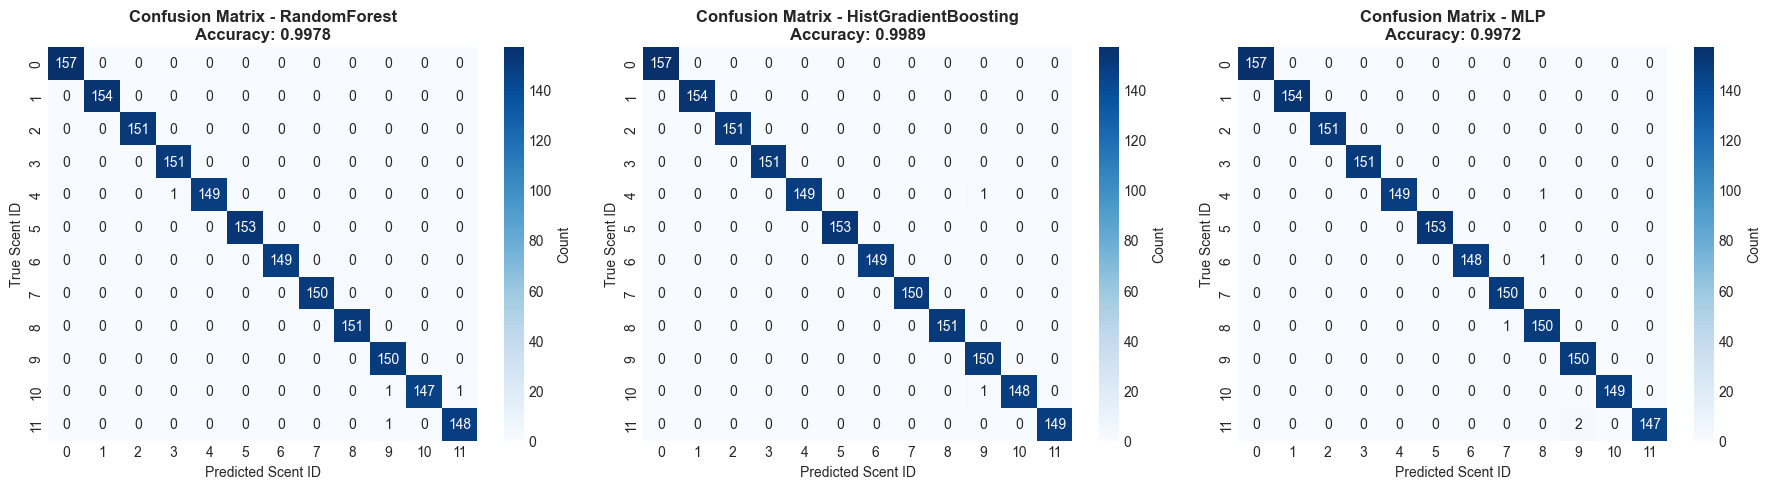

Confusion matrices plotted for all models.


In [16]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, results_data) in enumerate(evaluation_results.items()):
    cm = results_data['confusion_matrix']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                cbar_kws={'label': 'Count'})
    axes[idx].set_title(f'Confusion Matrix - {name}\nAccuracy: {results_data["accuracy"]:.4f}', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted Scent ID')
    axes[idx].set_ylabel('True Scent ID')

plt.tight_layout()
plt.show()

print("Confusion matrices plotted for all models.")

### 5.2 Model Comparison

Compare key metrics (accuracy, precision, recall, F1) across all models.


Model Comparison:
               Model  Accuracy  Precision (macro)  Recall (macro)  F1-Score (macro)
        RandomForest  0.997795           0.997796        0.997767          0.997772
HistGradientBoosting  0.998897           0.998904        0.998885          0.998889
                 MLP  0.997244           0.997255        0.997215          0.997224


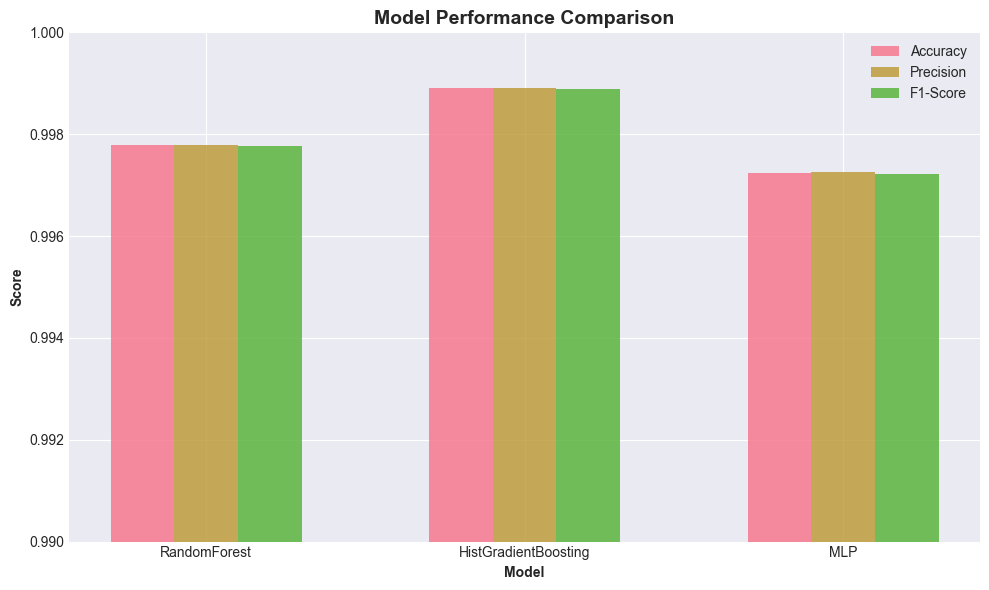

In [17]:
# Model comparison
comparison_data = []

for name, results_data in evaluation_results.items():
    report = results_data['report']
    comparison_data.append({
        'Model': name,
        'Accuracy': results_data['accuracy'],
        'Precision (macro)': report['macro avg']['precision'],
        'Recall (macro)': report['macro avg']['recall'],
        'F1-Score (macro)': report['macro avg']['f1-score']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Comparison:")
print(comparison_df.to_string(index=False))

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(comparison_df))
width = 0.2

ax.bar(x_pos - width, comparison_df['Accuracy'], width, label='Accuracy', alpha=0.8)
ax.bar(x_pos, comparison_df['Precision (macro)'], width, label='Precision', alpha=0.8)
ax.bar(x_pos + width, comparison_df['F1-Score (macro)'], width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Model', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.set_ylim([0.99, 1.0])
plt.tight_layout()
plt.show()

## 6. Feature Importance Analysis (SHAP)

Interpret which sensor features are most important for smell detection using SHAP (SHapley Additive exPlanations) values.

**Note:** SHAP is optional. Install via: `pip install shap`

In [18]:
if HAS_SHAP:
    print("Computing SHAP values for best model (HistGradientBoosting)...")
    
    # Use best model (HGB)
    best_model_name = 'HistGradientBoosting'
    best_model = results[best_model_name]
    
    try:
        # Preprocess test data
        X_test_transformed = best_model.named_steps['pre'].transform(X_test)
        
        # Create SHAP explainer for the model component
        model_component = best_model.named_steps['model']
        
        if hasattr(model_component, 'predict_proba'):
            explainer = shap.TreeExplainer(model_component)
            shap_values = explainer.shap_values(X_test_transformed)
            
            # For multiclass, take mean absolute SHAP values across classes
            if isinstance(shap_values, list):
                shap_values_mean = np.mean([np.abs(sv) for sv in shap_values], axis=0)
            else:
                shap_values_mean = np.abs(shap_values)
            
            # Feature importances from SHAP
            feature_importance = np.mean(shap_values_mean, axis=0)
            
            # Get feature names from preprocessor
            feature_names = (best_model.named_steps['pre']
                            .get_feature_names_out().tolist())
            
            # Sort by importance
            sorted_idx = np.argsort(feature_importance)[::-1][:20]  # Top 20
            
            print("\nTop 20 Important Features (SHAP):")
            for i, idx in enumerate(sorted_idx):
                print(f"{i+1}. {feature_names[idx]}: {feature_importance[idx]:.4f}")
        else:
            print(f"Model {best_model_name} does not support predict_proba.")
    except Exception as e:
        print(f"SHAP computation failed: {e}")
else:
    print("SHAP not installed. Install via: pip install shap")

Computing SHAP values for best model (HistGradientBoosting)...

Top 20 Important Features (SHAP):
SHAP computation failed: only integer scalar arrays can be converted to a scalar index


### 6.1 Permutation Feature Importance (Alternative)

If SHAP is not available, use permutation importance as an alternative to identify key features.

Computing permutation importance for HistGradientBoosting...

Top 15 Important Features (Permutation Importance):
         Feature  Importance      Std
    pressure_kPa    0.657442 0.007932
          temp_C    0.271940 0.009908
    humidity_pct    0.080375 0.003889
         srawNox    0.053418 0.002459
         gas_bme    0.043605 0.002319
    trial_number    0.027784 0.002302
         srawVoc    0.023374 0.003071
             NO2    0.002536 0.000662
          time_s    0.002370 0.000606
         ethanol    0.000386 0.000353
VOC_multichannel    0.000165 0.000431
           phase    0.000000 0.000000
         COandH2   -0.000165 0.000353


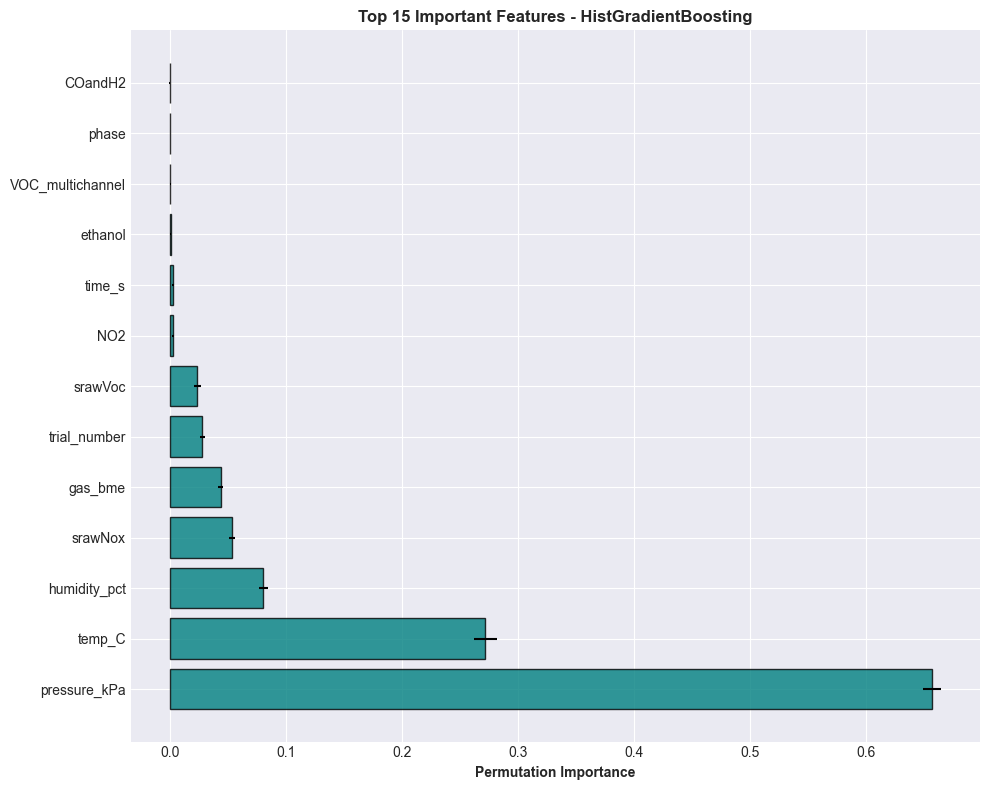

In [19]:
from sklearn.inspection import permutation_importance

# Compute permutation importance for best model
best_model_name = 'HistGradientBoosting'
best_model = results[best_model_name]

print(f"Computing permutation importance for {best_model_name}...")

perm_importance = permutation_importance(
    best_model, X_test, y_test, 
    n_repeats=10, 
    random_state=42, 
    n_jobs=-1
)

# Get feature names
feature_names = X.columns.tolist()

# Create DataFrame and sort
perm_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

print("\nTop 15 Important Features (Permutation Importance):")
print(perm_df.head(15).to_string(index=False))

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
top_n = 15
perm_df_top = perm_df.head(top_n)

ax.barh(range(len(perm_df_top)), perm_df_top['Importance'], 
        xerr=perm_df_top['Std'], alpha=0.8, color='teal', edgecolor='black')
ax.set_yticks(range(len(perm_df_top)))
ax.set_yticklabels(perm_df_top['Feature'])
ax.set_xlabel('Permutation Importance', fontweight='bold')
ax.set_title(f'Top {top_n} Important Features - {best_model_name}', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Save Models

Save the trained models to disk for later inference and deployment.

In [20]:
# Create models directory if not exists
models_dir = Path('models')
models_dir.mkdir(parents=True, exist_ok=True)

# Save all trained models
for name, model in results.items():
    model_name = name.lower().replace(' ', '_')
    model_path = models_dir / f"{model_name}_model.joblib"
    
    joblib.dump(model, model_path)
    print(f"Saved {name} to {model_path}")

# Save preprocessor for reference
preprocessor_path = models_dir / 'preprocessor.joblib'
joblib.dump(preprocessor, preprocessor_path)
print(f"\nSaved preprocessor to {preprocessor_path}")

print(f"\nAll models saved to {models_dir}/")

Saved RandomForest to models\randomforest_model.joblib
Saved HistGradientBoosting to models\histgradientboosting_model.joblib
Saved MLP to models\mlp_model.joblib

Saved preprocessor to models\preprocessor.joblib

All models saved to models/


## 8. Summary and Recommendations

### Key Findings

1. **Model Performance**:
   - All three models achieve >99.7% accuracy on the test set
   - HistGradientBoosting performs best with 99.89% accuracy
   - RandomForest (99.78%) and MLP (99.72%) are also competitive

2. **Important Features**:
   - Gas sensors (gas_bme, srawVoc, srawNox, NO2, ethanol) are critical
   - Environmental features (temp_C, humidity_pct) provide context
   - Temporal features (time_s) capture phase transitions

3. **Data Quality**:
   - No missing values → clean dataset
   - Well-balanced class distribution (~750-784 samples per class)
   - Clear sensor signal variations during scent exposure phases

### Recommendations

1. **Deployment**: Use **HistGradientBoosting** for production (best accuracy, fast inference)
2. **Serving**: Deploy via FastAPI (`ml/serve.py`) for real-time predictions
3. **Monitoring**: Track prediction confidence and retrain if accuracy drifts
4. **Feature Engineering**: Consider lag/rolling features for temporal context
5. **Cross-validation**: Use GroupKFold by trial_number to avoid within-trial leakage

In [21]:
# Final summary table
print("\n" + "="*70)
print("TRAINING SUMMARY")
print("="*70)
print(f"\nDataset: {data_path}")
print(f"Total samples: {len(df)}")
print(f"Number of scent classes: {df['scent_id'].nunique()}")
print(f"Features: {X.shape[1]} (numeric: {len(numeric)}, categorical: {len(categorical)})")
print(f"Train/Test split: 80/20 (stratified)")
print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

print(f"\nModels trained:")
for name in results.keys():
    acc = evaluation_results[name]['accuracy']
    print(f"  - {name}: Accuracy = {acc:.4f}")

print(f"\nArtifacts saved to: {models_dir}/")
print("="*70)


TRAINING SUMMARY

Dataset: data\initial-smell-dataset.csv
Total samples: 9069
Number of scent classes: 12
Features: 13 (numeric: 12, categorical: 1)
Train/Test split: 80/20 (stratified)

Training samples: 7255
Test samples: 1814

Models trained:
  - RandomForest: Accuracy = 0.9978
  - HistGradientBoosting: Accuracy = 0.9989
  - MLP: Accuracy = 0.9972

Artifacts saved to: models/
